This notebook contains sentiment labeling results from crawling data via Playstore about “Roblox” in Indonesia, as well as machine learning model training for sentiment analysis.
by Ifan Hakim

# Gathering Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import joblib

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# Import the Dataset

In [2]:
df = pd.read_csv("/content/roblox_playstore.csv")

display(df)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,a34478e4-b7f0-4e78-9d5a-9dcde8b014d3,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,nice game 🎯,5,0,2.691.868,2025-09-24 14:26:00,NaN,NaN,2.691.868
1,00e0814c-a587-47ab-8fe2-125ec476c6fe,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,best game ever made,4,0,NaN,2025-09-24 14:25:36,NaN,NaN,NaN
2,9c0a7b64-04e1-4b39-862d-537bcd23e5c9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,they should do a update on pls donate,5,0,2.689.880,2025-09-24 14:24:45,NaN,NaN,2.689.880
3,1d0e9996-6a5a-4a98-ae37-a7c97c202086,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It keeps on removing my accounts 😡,1,0,NaN,2025-09-24 14:24:26,NaN,NaN,NaN
4,d8eb5f06-05e7-4906-a632-73813f143f52,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,brooo roblox is so lag but I love roblox l ❤❤❤...,5,0,2.691.868,2025-09-24 14:23:48,NaN,NaN,2.691.868
...,...,...,...,...,...,...,...,...,...,...,...
3047,5c7f224f-7e04-4b77-b8c3-a7fd7bcb7ceb,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,THIS GAME IS MY FAVOURITE GAME THIS IS BEST GA...,5,0,NaN,2025-09-23 08:08:15,NaN,NaN,NaN
3048,16126579-77db-44cb-a12e-1273b51f02f5,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,bomboclat🍑,4,0,2.691.868,2025-09-23 08:08:12,NaN,NaN,2.691.868
3049,337ce3cc-59df-476b-88fa-75a22c80acc4,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,the best of the best,5,0,2.691.868,2025-09-23 08:08:02,NaN,NaN,2.691.868
3050,60a14d07-2f32-4668-885e-ba4c8bf254b9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"amazing 😍😍😍 game ,best ever!!",5,0,2.690.721,2025-09-23 08:07:52,NaN,NaN,2.690.721


# Preprocessing Data

In [3]:
# Check duplicated data that contains in Dataframe
total_duplicate = df.duplicated().sum()
print(f"Total duplicated data: {total_duplicate}")

Total duplicated data: 0


In [4]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
reviewId                   0
userName                   0
userImage                  0
content                    1
score                      0
thumbsUpCount              0
reviewCreatedVersion     701
at                         0
replyContent            3052
repliedAt               3052
appVersion               701
dtype: int64


In [5]:
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
def cleaningText(text):
  text = re.sub(r"@[A-Za-z0-9]+", "", text)# remove add
  text = re.sub(r"#[A-Za-z0-9]+", "", text)# remove hashtag
  text = re.sub(r"http\S+", "", text)# remove link
  text = re.sub(r"[0-9]+", "", text)# remove number
  text = re.sub(r"[^\w\s]", "", text)# remove character other than words and number
  text = re.sub(r"[^\x00-\x7F]+", "", text)

  text = text.replace("\n", " ")
  text = text.replace("\r", "")
  text = text.translate(str.maketrans("", "", string.punctuation))# remove punctuation
  text = text.strip(" ")
  return text

def casefoldingText(text):
  text = text.lower()
  return text

def tokenizeText(text):
  text = word_tokenize(text)
  return text

def filterText(text):
  listStopwords = set(stopwords.words("english"))
  filtered = []
  for i in text:
    if i not in listStopwords:
      filtered.append(i)
  return filtered

def stemmingText(text):
  stemmer = PorterStemmer()
  words = text.split()

  stemmed_words = [stemmer.stem(i) for i in text]

  stemmed_text = " ".join(stemmed_words)

  return stemmed_text

def toSentence(list_words):
  sentence = " ".join(i for i in list_words)
  return sentence

In [7]:
# Fill missing values in 'content' with "good enough!"
df['content'] = df['content'].fillna('good enough!')

# Clean text
df["cleaned_text"] = df["content"].apply(cleaningText)

# Lower text
df["text_caseFolding"] = df["cleaned_text"].apply(casefoldingText)

# Tokenize text
df["text_tokenized"] = df["text_caseFolding"].apply(tokenizeText)

# Remove Stopwords
df["text_stopwords"] = df["text_tokenized"].apply(filterText)

# Join to sentence
df["final_text"] = df["text_stopwords"].apply(toSentence)

In [8]:
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cleaned_text,text_caseFolding,text_tokenized,text_stopwords,final_text
0,a34478e4-b7f0-4e78-9d5a-9dcde8b014d3,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,nice game 🎯,5,0,2.691.868,2025-09-24 14:26:00,NaN,NaN,2.691.868,nice game,nice game,"[nice, game]","[nice, game]",nice game
1,00e0814c-a587-47ab-8fe2-125ec476c6fe,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,best game ever made,4,0,NaN,2025-09-24 14:25:36,NaN,NaN,NaN,best game ever made,best game ever made,"[best, game, ever, made]","[best, game, ever, made]",best game ever made
2,9c0a7b64-04e1-4b39-862d-537bcd23e5c9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,they should do a update on pls donate,5,0,2.689.880,2025-09-24 14:24:45,NaN,NaN,2.689.880,they should do a update on pls donate,they should do a update on pls donate,"[they, should, do, a, update, on, pls, donate]","[update, pls, donate]",update pls donate
3,1d0e9996-6a5a-4a98-ae37-a7c97c202086,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It keeps on removing my accounts 😡,1,0,NaN,2025-09-24 14:24:26,NaN,NaN,NaN,It keeps on removing my accounts,it keeps on removing my accounts,"[it, keeps, on, removing, my, accounts]","[keeps, removing, accounts]",keeps removing accounts
4,d8eb5f06-05e7-4906-a632-73813f143f52,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,brooo roblox is so lag but I love roblox l ❤❤❤...,5,0,2.691.868,2025-09-24 14:23:48,NaN,NaN,2.691.868,brooo roblox is so lag but I love roblox l,brooo roblox is so lag but i love roblox l,"[brooo, roblox, is, so, lag, but, i, love, rob...","[brooo, roblox, lag, love, roblox, l]",brooo roblox lag love roblox l
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,5c7f224f-7e04-4b77-b8c3-a7fd7bcb7ceb,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,THIS GAME IS MY FAVOURITE GAME THIS IS BEST GA...,5,0,NaN,2025-09-23 08:08:15,NaN,NaN,NaN,THIS GAME IS MY FAVOURITE GAME THIS IS BEST GA...,this game is my favourite game this is best ga...,"[this, game, is, my, favourite, game, this, is...","[game, favourite, game, best, game, played, life]",game favourite game best game played life
3048,16126579-77db-44cb-a12e-1273b51f02f5,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,bomboclat🍑,4,0,2.691.868,2025-09-23 08:08:12,NaN,NaN,2.691.868,bomboclat,bomboclat,[bomboclat],[bomboclat],bomboclat
3049,337ce3cc-59df-476b-88fa-75a22c80acc4,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,the best of the best,5,0,2.691.868,2025-09-23 08:08:02,NaN,NaN,2.691.868,the best of the best,the best of the best,"[the, best, of, the, best]","[best, best]",best best
3050,60a14d07-2f32-4668-885e-ba4c8bf254b9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"amazing 😍😍😍 game ,best ever!!",5,0,2.690.721,2025-09-23 08:07:52,NaN,NaN,2.690.721,amazing game best ever,amazing game best ever,"[amazing, game, best, ever]","[amazing, game, best, ever]",amazing game best ever


In [9]:
print("No review: ", len(df[df["final_text"] == ""]))

No review:  59


# Labeling the Datasets

In [10]:
def labeling(row):
  compound_score = row['compound_score']
  score = row['score']
  polarity = ""

  if compound_score >= 0.4 and score > 3:
    polarity = "positive"
  elif compound_score > -0.4 and compound_score < 0.4 and score == 3:
    polarity = "neutral"
  elif compound_score <= -0.4 and score < 3:
    polarity = "negative"
  elif compound_score >= 0.4:
      polarity = "positive"
  elif compound_score > -0.4 and compound_score < 0.4:
      polarity = "neutral"
  else:
      polarity = "negative"


  return polarity

In [11]:
sid = SentimentIntensityAnalyzer()

texts = df["final_text"]

compound_score = []

for text in texts:
  sentiment_scores = sid.polarity_scores(text)
  compound_score.append(sentiment_scores["compound"])

df["compound_score"] = compound_score

df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cleaned_text,text_caseFolding,text_tokenized,text_stopwords,final_text,compound_score
0,a34478e4-b7f0-4e78-9d5a-9dcde8b014d3,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,nice game 🎯,5,0,2.691.868,2025-09-24 14:26:00,NaN,NaN,2.691.868,nice game,nice game,"[nice, game]","[nice, game]",nice game,0.4215
1,00e0814c-a587-47ab-8fe2-125ec476c6fe,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,best game ever made,4,0,NaN,2025-09-24 14:25:36,NaN,NaN,NaN,best game ever made,best game ever made,"[best, game, ever, made]","[best, game, ever, made]",best game ever made,0.6369
2,9c0a7b64-04e1-4b39-862d-537bcd23e5c9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,they should do a update on pls donate,5,0,2.689.880,2025-09-24 14:24:45,NaN,NaN,2.689.880,they should do a update on pls donate,they should do a update on pls donate,"[they, should, do, a, update, on, pls, donate]","[update, pls, donate]",update pls donate,0.0772
3,1d0e9996-6a5a-4a98-ae37-a7c97c202086,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It keeps on removing my accounts 😡,1,0,NaN,2025-09-24 14:24:26,NaN,NaN,NaN,It keeps on removing my accounts,it keeps on removing my accounts,"[it, keeps, on, removing, my, accounts]","[keeps, removing, accounts]",keeps removing accounts,0.0000
4,d8eb5f06-05e7-4906-a632-73813f143f52,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,brooo roblox is so lag but I love roblox l ❤❤❤...,5,0,2.691.868,2025-09-24 14:23:48,NaN,NaN,2.691.868,brooo roblox is so lag but I love roblox l,brooo roblox is so lag but i love roblox l,"[brooo, roblox, is, so, lag, but, i, love, rob...","[brooo, roblox, lag, love, roblox, l]",brooo roblox lag love roblox l,0.4215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,5c7f224f-7e04-4b77-b8c3-a7fd7bcb7ceb,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,THIS GAME IS MY FAVOURITE GAME THIS IS BEST GA...,5,0,NaN,2025-09-23 08:08:15,NaN,NaN,NaN,THIS GAME IS MY FAVOURITE GAME THIS IS BEST GA...,this game is my favourite game this is best ga...,"[this, game, is, my, favourite, game, this, is...","[game, favourite, game, best, game, played, life]",game favourite game best game played life,0.7650
3048,16126579-77db-44cb-a12e-1273b51f02f5,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,bomboclat🍑,4,0,2.691.868,2025-09-23 08:08:12,NaN,NaN,2.691.868,bomboclat,bomboclat,[bomboclat],[bomboclat],bomboclat,0.0000
3049,337ce3cc-59df-476b-88fa-75a22c80acc4,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,the best of the best,5,0,2.691.868,2025-09-23 08:08:02,NaN,NaN,2.691.868,the best of the best,the best of the best,"[the, best, of, the, best]","[best, best]",best best,0.8555
3050,60a14d07-2f32-4668-885e-ba4c8bf254b9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"amazing 😍😍😍 game ,best ever!!",5,0,2.690.721,2025-09-23 08:07:52,NaN,NaN,2.690.721,amazing game best ever,amazing game best ever,"[amazing, game, best, ever]","[amazing, game, best, ever]",amazing game best ever,0.8402


In [12]:
df["label"] = df.apply(labeling, axis=1)

In [13]:
df["label"].value_counts()

,count
label,
positive,1907
neutral,922
negative,223


In [14]:
df.to_csv("/content/roblox_sentiment_manual.csv", index=False)

In [15]:
df = pd.read_csv("/content/roblox_sentiment_manual.csv")
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cleaned_text,text_caseFolding,text_tokenized,text_stopwords,final_text,compound_score,label
0,a34478e4-b7f0-4e78-9d5a-9dcde8b014d3,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,nice game 🎯,5,0,2.691.868,2025-09-24 14:26:00,NaN,NaN,2.691.868,nice game,nice game,"['nice', 'game']","['nice', 'game']",nice game,0.4215,positive
1,00e0814c-a587-47ab-8fe2-125ec476c6fe,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,best game ever made,4,0,NaN,2025-09-24 14:25:36,NaN,NaN,NaN,best game ever made,best game ever made,"['best', 'game', 'ever', 'made']","['best', 'game', 'ever', 'made']",best game ever made,0.6369,positive
2,9c0a7b64-04e1-4b39-862d-537bcd23e5c9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,they should do a update on pls donate,5,0,2.689.880,2025-09-24 14:24:45,NaN,NaN,2.689.880,they should do a update on pls donate,they should do a update on pls donate,"['they', 'should', 'do', 'a', 'update', 'on', ...","['update', 'pls', 'donate']",update pls donate,0.0772,neutral
3,1d0e9996-6a5a-4a98-ae37-a7c97c202086,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It keeps on removing my accounts 😡,1,0,NaN,2025-09-24 14:24:26,NaN,NaN,NaN,It keeps on removing my accounts,it keeps on removing my accounts,"['it', 'keeps', 'on', 'removing', 'my', 'accou...","['keeps', 'removing', 'accounts']",keeps removing accounts,0.0000,neutral
4,d8eb5f06-05e7-4906-a632-73813f143f52,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,brooo roblox is so lag but I love roblox l ❤❤❤...,5,0,2.691.868,2025-09-24 14:23:48,NaN,NaN,2.691.868,brooo roblox is so lag but I love roblox l,brooo roblox is so lag but i love roblox l,"['brooo', 'roblox', 'is', 'so', 'lag', 'but', ...","['brooo', 'roblox', 'lag', 'love', 'roblox', 'l']",brooo roblox lag love roblox l,0.4215,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,5c7f224f-7e04-4b77-b8c3-a7fd7bcb7ceb,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,THIS GAME IS MY FAVOURITE GAME THIS IS BEST GA...,5,0,NaN,2025-09-23 08:08:15,NaN,NaN,NaN,THIS GAME IS MY FAVOURITE GAME THIS IS BEST GA...,this game is my favourite game this is best ga...,"['this', 'game', 'is', 'my', 'favourite', 'gam...","['game', 'favourite', 'game', 'best', 'game', ...",game favourite game best game played life,0.7650,positive
3048,16126579-77db-44cb-a12e-1273b51f02f5,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,bomboclat🍑,4,0,2.691.868,2025-09-23 08:08:12,NaN,NaN,2.691.868,bomboclat,bomboclat,['bomboclat'],['bomboclat'],bomboclat,0.0000,neutral
3049,337ce3cc-59df-476b-88fa-75a22c80acc4,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,the best of the best,5,0,2.691.868,2025-09-23 08:08:02,NaN,NaN,2.691.868,the best of the best,the best of the best,"['the', 'best', 'of', 'the', 'best']","['best', 'best']",best best,0.8555,positive
3050,60a14d07-2f32-4668-885e-ba4c8bf254b9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"amazing 😍😍😍 game ,best ever!!",5,0,2.690.721,2025-09-23 08:07:52,NaN,NaN,2.690.721,amazing game best ever,amazing game best ever,"['amazing', 'game', 'best', 'ever']","['amazing', 'game', 'best', 'ever']",amazing game best ever,0.8402,positive


# Function for Modeling

In [16]:
df = pd.read_csv("/content/roblox_sentiment_manual.csv")
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,cleaned_text,text_caseFolding,text_tokenized,text_stopwords,final_text,compound_score,label
0,a34478e4-b7f0-4e78-9d5a-9dcde8b014d3,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,nice game 🎯,5,0,2.691.868,2025-09-24 14:26:00,NaN,NaN,2.691.868,nice game,nice game,"['nice', 'game']","['nice', 'game']",nice game,0.4215,positive
1,00e0814c-a587-47ab-8fe2-125ec476c6fe,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,best game ever made,4,0,NaN,2025-09-24 14:25:36,NaN,NaN,NaN,best game ever made,best game ever made,"['best', 'game', 'ever', 'made']","['best', 'game', 'ever', 'made']",best game ever made,0.6369,positive
2,9c0a7b64-04e1-4b39-862d-537bcd23e5c9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,they should do a update on pls donate,5,0,2.689.880,2025-09-24 14:24:45,NaN,NaN,2.689.880,they should do a update on pls donate,they should do a update on pls donate,"['they', 'should', 'do', 'a', 'update', 'on', ...","['update', 'pls', 'donate']",update pls donate,0.0772,neutral
3,1d0e9996-6a5a-4a98-ae37-a7c97c202086,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It keeps on removing my accounts 😡,1,0,NaN,2025-09-24 14:24:26,NaN,NaN,NaN,It keeps on removing my accounts,it keeps on removing my accounts,"['it', 'keeps', 'on', 'removing', 'my', 'accou...","['keeps', 'removing', 'accounts']",keeps removing accounts,0.0000,neutral
4,d8eb5f06-05e7-4906-a632-73813f143f52,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,brooo roblox is so lag but I love roblox l ❤❤❤...,5,0,2.691.868,2025-09-24 14:23:48,NaN,NaN,2.691.868,brooo roblox is so lag but I love roblox l,brooo roblox is so lag but i love roblox l,"['brooo', 'roblox', 'is', 'so', 'lag', 'but', ...","['brooo', 'roblox', 'lag', 'love', 'roblox', 'l']",brooo roblox lag love roblox l,0.4215,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,5c7f224f-7e04-4b77-b8c3-a7fd7bcb7ceb,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,THIS GAME IS MY FAVOURITE GAME THIS IS BEST GA...,5,0,NaN,2025-09-23 08:08:15,NaN,NaN,NaN,THIS GAME IS MY FAVOURITE GAME THIS IS BEST GA...,this game is my favourite game this is best ga...,"['this', 'game', 'is', 'my', 'favourite', 'gam...","['game', 'favourite', 'game', 'best', 'game', ...",game favourite game best game played life,0.7650,positive
3048,16126579-77db-44cb-a12e-1273b51f02f5,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,bomboclat🍑,4,0,2.691.868,2025-09-23 08:08:12,NaN,NaN,2.691.868,bomboclat,bomboclat,['bomboclat'],['bomboclat'],bomboclat,0.0000,neutral
3049,337ce3cc-59df-476b-88fa-75a22c80acc4,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,the best of the best,5,0,2.691.868,2025-09-23 08:08:02,NaN,NaN,2.691.868,the best of the best,the best of the best,"['the', 'best', 'of', 'the', 'best']","['best', 'best']",best best,0.8555,positive
3050,60a14d07-2f32-4668-885e-ba4c8bf254b9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"amazing 😍😍😍 game ,best ever!!",5,0,2.690.721,2025-09-23 08:07:52,NaN,NaN,2.690.721,amazing game best ever,amazing game best ever,"['amazing', 'game', 'best', 'ever']","['amazing', 'game', 'best', 'ever']",amazing game best ever,0.8402,positive


In [17]:
def accuracy(model):
  y_pred_train = model.predict(X_train)
  y_pred = model.predict(X_test)

  accuracy_train = accuracy_score(y_train, y_pred_train)
  accuracy_test = accuracy_score(y_test, y_pred)

  print("train accuracy: ", accuracy_train)
  print("test accuracy: ", accuracy_test)

In [18]:
def accuracy_value(model):
  y_pred_train = model.predict(X_train)
  y_pred = model.predict(X_test)

  accuracy_train = accuracy_score(y_train, y_pred_train)
  accuracy_test = accuracy_score(y_test, y_pred)

  return accuracy_train, accuracy_test

# Feature Extraction & Engineering

In [19]:
# Fill NaN values in 'final_text' with an empty string
df['final_text'] = df['final_text'].fillna('good, but need to improve')

# Apply TF-IDF
tfidf = TfidfVectorizer(max_features=5000, min_df=17, max_df=0.7)
X_tfidf = tfidf.fit_transform(df['final_text'])

In [20]:
X = X_tfidf, df[['score']]
y = df["label"]

In [21]:
# Save the Feature
feature_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
feature_df

,account,alot,also,always,amazing,anymore,anything,app,avatar,awesome,...,way,well,wifi,work,world,worst,would,wow,year,years
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3047,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3048,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3049,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3050,0.0,0.0,0.0,0.0,0.647451,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Label Encoding
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(y)
df["label_encoded"].value_counts()

,count
label_encoded,
2,1907
1,922
0,223


In [23]:
y_encoded = df["label_encoded"]

In [24]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Scenario 1: TF-IDF Random Forest

In [25]:
rf_tfidf = RandomForestClassifier(random_state=42,)
rf_tfidf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [26]:
accuracy(rf_tfidf)

train accuracy:  0.9832036050798852
test accuracy:  0.851063829787234


In [27]:
rf_tfidf_accuracy_train = accuracy_value(rf_tfidf)[0]
rf_tfidf_accuracy_test = accuracy_value(rf_tfidf)[1]

# Scenario 2: TF-IDF Logistic Regression

In [28]:
lr_tfidf = LogisticRegression(multi_class="multinomial",n_jobs=-1, solver="newton-cholesky",)
lr_tfidf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial', n_jobs=-1,
                   solver='newton-cholesky')

In [29]:
accuracy(lr_tfidf)

train accuracy:  0.8865219172470299
test accuracy:  0.8445171849427169


In [30]:
lr_tfidf_accuracy_train = accuracy_value(lr_tfidf)[0]
lr_tfidf_accuracy_test = accuracy_value(lr_tfidf)[1]

# Scenario 3: TF-IDF SVM

In [31]:
svm_tfidf = LinearSVC(random_state=42, dual=False, tol=1e-5)
svm_tfidf.fit(X_train, y_train)

LinearSVC(dual=False, random_state=42, tol=1e-05)

In [32]:
accuracy(svm_tfidf)

train accuracy:  0.9020893076607948
test accuracy:  0.8527004909983633


In [33]:
svm_tfidf_accuracy_train = accuracy_value(svm_tfidf)[0]
svm_tfidf_accuracy_test = accuracy_value(svm_tfidf)[1]

# Comparison of All Models

In [34]:
results_df = pd.DataFrame({
    'Model': ['TF-IDF Random Forest', 'TF-IDF Logistic Regression', 'TF-IDF SVM'],
    'Accuracy Train': [rf_tfidf_accuracy_train, lr_tfidf_accuracy_train, svm_tfidf_accuracy_train],
    'Accuracy Test': [rf_tfidf_accuracy_test, lr_tfidf_accuracy_test, svm_tfidf_accuracy_test]
})

results_df[["Model", "Accuracy Test"]].sort_values("Accuracy Test", ascending=False)

,Model,Accuracy Test
2,TF-IDF SVM,0.852700
0,TF-IDF Random Forest,0.851064
1,TF-IDF Logistic Regression,0.844517


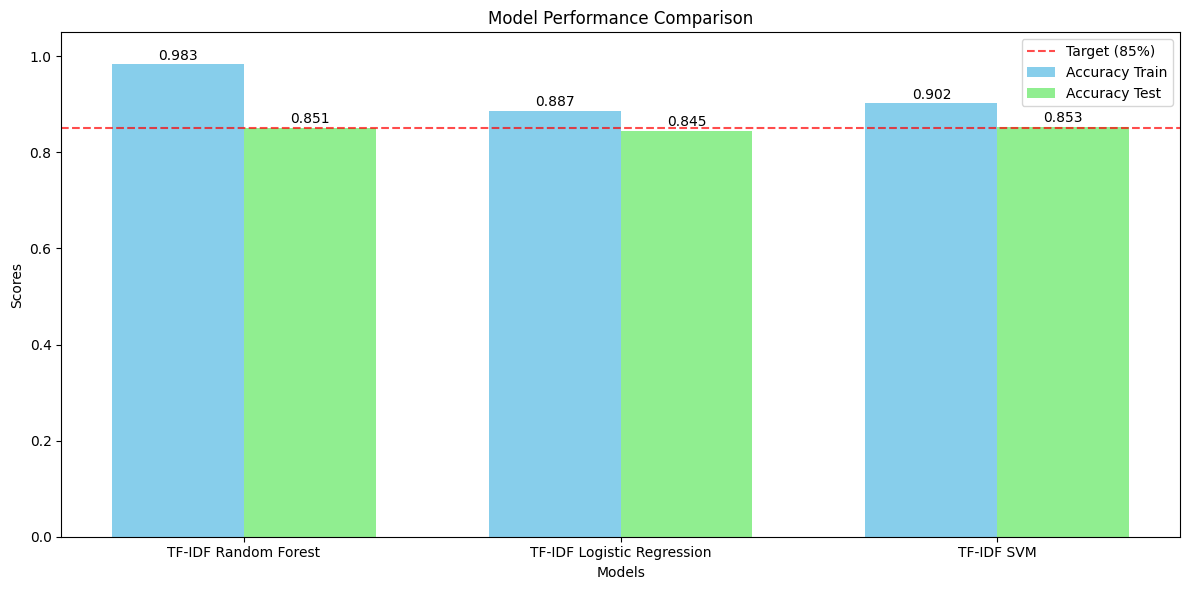

In [35]:
# Visualization of model performance
plt.figure(figsize=(12, 6))
model_names = results_df['Model']
accuracies_train = results_df['Accuracy Train']
accuracies_test = results_df['Accuracy Test']

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, accuracies_train, width, label='Accuracy Train', color='skyblue')
plt.bar(x + width/2, accuracies_test, width, label='Accuracy Test', color='lightgreen')


plt.axhline(y=0.85, color='red', linestyle='--', alpha=0.7, label='Target (85%)')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()
plt.ylim(0, 1.05) # Extend y-limit slightly to fit text labels

# Add values on bars
for i, (acc_train, acc_test) in enumerate(zip(accuracies_train, accuracies_test)):
    plt.text(i - width/2, acc_train + 0.01, f'{acc_train:.3f}', ha='center')
    plt.text(i + width/2, acc_test + 0.01, f'{acc_test:.3f}', ha='center')


plt.tight_layout()
plt.show()

# Save Models

In [36]:
# Save the Random Forest model and preprocessing objects
model_package = {
    'model': rf_tfidf,
    'tfidf': tfidf,
    'label_encoder': le,
    'accuracy': rf_tfidf_accuracy_test,
    'model_name': 'TF-IDF Random Forest'
}

joblib.dump(model_package, 'sentiment_roblox.pkl')
print("Model saved as 'sentiment_roblox.pkl'")

Model saved as 'sentiment_roblox.pkl'


# Inference

In [37]:
# Input new texts
new_input = input("Masukkan kalimat baru: ")

# Preprocessing new_input
new_input_cleaned = cleaningText(new_input)
new_input_casefolded = casefoldingText(new_input_cleaned)
new_input_tokenized = tokenizeText(new_input_casefolded)
new_input_filtered = filterText(new_input_tokenized)
new_input_final = toSentence(new_input_filtered)

# Transform new_input_final using the fitted TF-IDF vectorizer
new_input_tfidf = tfidf.transform([new_input_final])

# Predict new sentiment using the trained model (Random Forest in this case)
predict_sentiment = svm_tfidf.predict(new_input_tfidf)

# Result
if predict_sentiment[0] == 1:
  print("Neutral")
elif predict_sentiment[0] == 2:
  print("Positive")
else:
    print("Negative")

Masukkan kalimat baru: this game is really useless
Negative
